In [3]:
import healpy as hp
import pylab as mplot
%pylab inline
import astropy.io.fits as pf
import astropy.io.fits as fits
import numpy as np
import scipy 
import kmeans_radec
%matplotlib inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Making a WaZP Random

In [4]:
# Some necessary functions from Chihway

def radec2thetaphi(ra, dec, nside):
    """
    Convert RA DEC in degrees to THETA and PHI in Healpix 
    convention. 
    """

    theta = (90.0 - dec)*np.pi/180.0
    phi = ra*np.pi/180.0
    return theta, phi

def make_mask(ra, dec, nmin=1, nside=4096):
    """
    Take RA, DEC, build a binary mask just by assigning 
    1 to pixels with count>=nmin and 0 otherwise. Mask 
    is in Healpix format with assigned nside. 
    """
    mask = np.zeros(hp.nside2npix(nside))
    theta, phi = radec2thetaphi(ra, dec, nside)
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    for i in range(len(pix)):
        mask[pix[i]] += 1
    mask[mask>=nmin] = 1
    mask[mask!=1] = 0

    return mask

def make_random(mask, ramin, ramax, decmin, decmax, N=1000, nside=4096, seed=100):
    """
    Create N random points within a given mask.
    """

    #print('Building the random catalog...')

    np.random.seed(seed)
    ra_rand = (np.random.random(N)* (ramax - ramin))+ramin
    v = np.random.random(N)
    #print len(v)
    vmin = np.cos((90.0+decmin)/180.*np.pi)
    vmax = np.cos((90.0+decmax)/180.*np.pi)
    v *= (vmax-vmin)
    v += vmin
    #v *= 2
    #v -= 1
    dec_rand = np.arccos(v)
    np.rad2deg(dec_rand,dec_rand)
    dec_rand -= 90.0
    #dec_rand_se =((dec_rand < decmax)&(dec_rand > decmin))
    #ra_rand, dec_rand = ra_rand[dec_rand_se],dec_rand[dec_rand_se]
    #print len(ra_rand)
    #print 'Masking the random catalog...'

    #Converting degrees into radians
    theta_rand = (90.0 - dec_rand)*np.pi/180.
    phi_rand = ra_rand*np.pi/180.
    pix_rand = hp.ang2pix(nside, theta_rand, phi_rand, nest=False)

    goodm, = np.where(mask[pix_rand]==1)
    ra_rand = ra_rand[goodm]
    dec_rand = dec_rand[goodm]
    #print(len(ra_rand))

    return ra_rand, dec_rand

In [107]:
# Make the random
# Use N = 612000, so that you get ~142200 random clusters, which is 20*(number of actual clusters)
ra_rand, dec_rand = make_random(mask_w, 0.004271, 359.990874, -67.379043, -38.201655, 612000)
# Make everything else just ones
w,z, Lambda, jkid = np.ones(len(ra_rand)),np.ones(len(ra_rand)),np.ones(len(ra_rand)),np.ones(len(ra_rand))
print(len(ra_rand))

141984


In [110]:
# Write random information to a fits file (uncomment last line to actually do this)

col1 = fits.Column(name='RA', format='E', array=ra_rand)
col2 = fits.Column(name='DEC', format= 'E', array=dec_rand)
col3 = fits.Column(name='Z', format='E', array=z)
col4 = fits.Column(name='LAMBDA', format='E', array = Lambda)
col5 = fits.Column(name='W', format='E', array=w)
col6 = fits.Column(name='JK', format='E', array=jkid)

cols_ran = fits.ColDefs([col1, col2, col3, col4, col5, col6])
hdu_ran = fits.BinTableHDU.from_columns(cols_ran)
#hdu_ran.writeto('./Fits_files/WaZP_cluster_rand_2.fits')

## Extracting Sigmag for WaZP Data – Run 1

In [111]:
# Read in the WaZP data (Everything from WaZP is denoted with a '_u' at the end)
hdu2 = fits.open('/Users/arielamsellem/Desktop/Research/Initial_Codes/wazp_cluster_newz.fits')
data_u = hdu2[1].data
cols_u = hdu2[1].columns
print(cols_u.names)

ra_u = data_u.field('ra')
dec_u = data_u.field('dec')
R_u = data_u.field('RADIUS_ISO_MPC')
z_u = data_u.field('zp')
rich_u = data_u.field('NGals')
drich_u = data_u.field('e_ngals')

# Write a fits file for WaZP Clusters in the column formating necessary 
# (uncomment hdu.writeto('./WaZP_cluster.fits') to do this)
ra = fits.Column(name='RA', format='E', array=ra_u)
dec = fits.Column(name='DEC', format= 'E', array=dec_u)
z = fits.Column(name='Z', format='E', array=z_u)
ngal = fits.Column(name='LAMBDA', format='E', array = rich_u)
jk = fits.Column(name='JK', format='E', array=jkid)

cols = fits.ColDefs([ra, dec, z, ngal, jk])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('./WaZP_cluster.fits')

['SeqNr', 'DETECTION_TILE', 'IZ_INIT', 'IZ_FINAL', 'PEAK_ID_TILE_IZ', 'ID_IN_TILE', 'RA', 'DEC', 'zp', 'zp_median', 'Z_INIT', 'ZMIN_CL', 'ZMAX_CL', 'ZMIN_95_CL', 'ZMAX_95_CL', 'MSTAR_CL', 'XPEAK', 'YPEAK', 'RADIUS_ISO_MPC', 'RADIUS_SADDLE_MPC', 'MAXWAVE', 'FLUX_WAVE', 'FLAG_MERGE', 'SIGMA_DZ_INIT', 'SIGMA_DZ_EFF', 'FLAG_ZP', 'NGAL_FOR_ZP', 'FLAG_IZ', 'GLOBAL_NBKG_ZM', 'GLOBAL_LBKG_ZM', 'SIG_NBKG_ZM', 'SIG_LBKG_ZM', 'LOCAL_NBKG_ZM', 'LOCAL_LBKG_ZM', 'AREA_LOCAL_BKG', 'MASKED_FRAC_1MPC', 'MASKED_FRAC_05MPC', 'MASKED_FRAC_03MPC', 'SNR', 'SNR_NGALS', 'SNR_LGALS', 'CONTRAST_NGALS', 'CONTRAST_LGALS', 'DMAG_CORE', 'DMAG_BCG', 'DIST_BCG', 'NGALS_TEST', 'NGALS_CEN', 'LGALS_CEN', 'LOCAL_NBKG', 'LOCAL_LBKG', 'GLOBAL_NBKG', 'GLOBAL_LBKG', 'SIG_NBKG', 'SIG_LBKG', 'OUT_OF_CYL', 'CYL_NSL', 'PARENT_CYL_NSL', 'ZMIN_CYL', 'ZMAX_CYL', 'IZ_MIN_CYL', 'IZ_MAX_CYL', 'CONTRAST_CYL', 'NMAX_CYL', 'KING_Rc', 'KING_D0', 'KING_CHI2', 'KING_NFIT', 'RADIUS_MPC', 'RADIUS_AMIN', 'RADIUS_MAX_CONTRAST', 'RADIUS_SCALING'

In [75]:
W = pf.open('./Fits_files/WaZP_cluster.fits')[1].data
cols = pf.open('./Fits_files/WaZP_cluster.fits')[1].columns
print(cols)
    
# The cuts on WaZP clusters in redshift and richness/ngal
arr_z = np.where((W['Z']>=0.2) & (W['Z']<=0.55))
arr_l = np.where((W['lambda']>=20.) & (W['lambda']<=110.))

num = []
for valz in arr_z[0]:
    for vall in arr_l[0]:
        if valz == vall:
            num.append(valz)
            
print('Number of WaZP Clusters after cuts: ' + str(len(num)))

ColDefs(
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'LAMBDA'; format = 'E'
    name = 'JK'; format = 'E'
)
Number of WaZP Clusters after cuts: 7110


In [76]:
# Sanity Check: Make sure there are no duplicate clusters in the number of WaZP clusters list
def anydup(thelist):
  seen = set()
  for x in thelist:
    if x in seen: return True
    seen.add(x)
  return False

print('Are there any duplicates in the WaZP cluster list? ' + str(anydup(num)))

Are there any duplicates in the WaZP cluster list? False


<IPython.core.display.Javascript object>


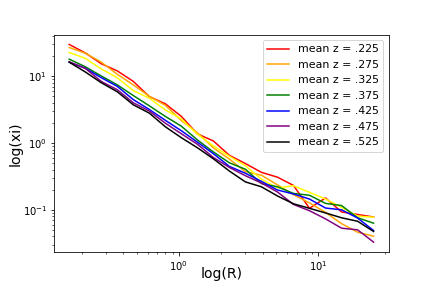

In [63]:
# After Running measure_Sigmag_WaZP.py...

%matplotlib notebook

n0 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_0.npz')
n1 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_1.npz')
n2 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_2.npz')
n3 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_3.npz')
n4 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_4.npz')
n5 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_5.npz')
n6 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_6.npz')

fig, ax = plt.subplots()
plt.plot(n0['R'],n0['xi'], color = 'red', label = 'mean z = .225')
plt.plot(n1['R'],n1['xi'], color = 'orange', label = 'mean z = .275')
plt.plot(n2['R'],n2['xi'], color = 'yellow', label = 'mean z = .325')
plt.plot(n3['R'],n3['xi'], color = 'green', label = 'mean z = .375')
plt.plot(n4['R'],n4['xi'], color = 'blue', label = 'mean z = .425')
plt.plot(n5['R'],n5['xi'], color = 'purple', label = 'mean z = .475')
plt.plot(n6['R'],n6['xi'], color = 'k', label = 'mean z = .525')
plt.xlabel('log(R)', fontsize = 14, labelpad = -6.)
plt.ylabel('log(xi)', fontsize = 14, labelpad = 0)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize = 11)
plt.show()
#plt.savefig('./Sigmag_WaZP_results/Sigmag_WaZP_results.png', dpi = 600)


In [61]:
print(n0['ave_dens'])

3.4480416675136345


## Extracting Sigmag for WaZP Data – Run 2 (More clusters in WaZP Random)

<IPython.core.display.Javascript object>


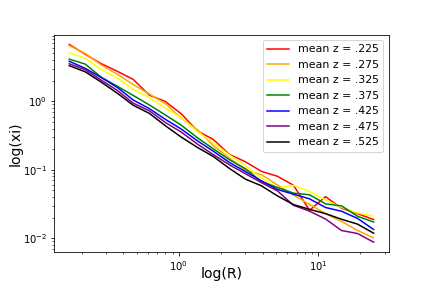

In [121]:
# After Running measure_Sigmag_WaZP.py...

n0 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_0.npz')
n1 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_1.npz')
n2 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_2.npz')
n3 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_3.npz')
n4 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_4.npz')
n5 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_5.npz')
n6 = np.load('./Sigmag_WaZP_results_run2/Sigmag_WaZP_6.npz')

fig, ax = plt.subplots()
plt.plot(n0['R'],n0['xi'], color = 'red', label = 'mean z = .225')
plt.plot(n1['R'],n1['xi'], color = 'orange', label = 'mean z = .275')
plt.plot(n2['R'],n2['xi'], color = 'yellow', label = 'mean z = .325')
plt.plot(n3['R'],n3['xi'], color = 'green', label = 'mean z = .375')
plt.plot(n4['R'],n4['xi'], color = 'blue', label = 'mean z = .425')
plt.plot(n5['R'],n5['xi'], color = 'purple', label = 'mean z = .475')
plt.plot(n6['R'],n6['xi'], color = 'k', label = 'mean z = .525')
plt.xlabel('log(R)', fontsize = 14, labelpad = -6.)
plt.ylabel('log(xi)', fontsize = 14, labelpad = 0)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize = 11)
plt.show()
#plt.savefig('./Sigmag_WaZP_results_run2/Sigmag_WaZP_results.png', dpi = 600)


In [5]:
xyz = pf.open('./Fits_files/WaZP_cluster_rand_2.fits')[1].data
print(xyz['z'])

[1. 1. 1. ... 1. 1. 1.]
